## Step 0. configurations

In [42]:
import warnings
warnings.filterwarnings("ignore")

## Step 1. reading data and importing libraries

In [43]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

In [44]:
df = pd.read_csv("../Car details v3.csv")
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


## Step 2. understanding the data

In [45]:
df.shape

(8128, 13)

In [46]:
df.columns

Index(['name', 'year', 'selling_price', 'km_driven', 'fuel', 'seller_type',
       'transmission', 'owner', 'mileage', 'engine', 'max_power', 'torque',
       'seats'],
      dtype='object')

In [47]:
df.index

RangeIndex(start=0, stop=8128, step=1)

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8128 non-null   object 
 1   year           8128 non-null   int64  
 2   selling_price  8128 non-null   int64  
 3   km_driven      8128 non-null   int64  
 4   fuel           8128 non-null   object 
 5   seller_type    8128 non-null   object 
 6   transmission   8128 non-null   object 
 7   owner          8128 non-null   object 
 8   mileage        7907 non-null   object 
 9   engine         7907 non-null   object 
 10  max_power      7913 non-null   object 
 11  torque         7906 non-null   object 
 12  seats          7907 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 825.6+ KB


In [49]:
df.describe()

,year,selling_price,km_driven,seats
count,8128.000000,8.128000e+03,8.128000e+03,7907.000000
mean,2013.804011,6.382718e+05,6.981951e+04,5.416719
std,4.044249,8.062534e+05,5.655055e+04,0.959588
min,1983.000000,2.999900e+04,1.000000e+00,2.000000
25%,2011.000000,2.549990e+05,3.500000e+04,5.000000
50%,2015.000000,4.500000e+05,6.000000e+04,5.000000
75%,2017.000000,6.750000e+05,9.800000e+04,5.000000
max,2020.000000,1.000000e+07,2.360457e+06,14.000000


## Step 2b. Feature Engineering

New column `make` derived from column `name`

In [50]:
if "name" in df.columns:
    df["make"] = df["name"].str.split(" ").str.get(0)
    df.drop(columns=["name"], inplace=True)

New columns `age_of_car` derived from column `year`

In [51]:
import datetime
current_year = datetime.datetime.now().year

df["age_of_car"] = df["year"].apply(lambda x: current_year - x)

New column `mileage_per_year` derived from columns `km_driven` and `age_of_car`

In [52]:
df["mileage_per_year"] = df["km_driven"] / df["age_of_car"]

New column `engine_cc`, derived from `engine` to just contain the numeric value instead of a string ending with "CC"

In [53]:
if "engine" in df.columns:
    df["engine_cc"] = df["engine"].str.split(" ").str.get(0).fillna(0).astype(int)
    df = df.drop(columns=["engine"], axis=1)

New column `power_to_weight_ratio` derived from column `max_power` and `seats`

In [54]:
if "max_power" in df.columns:
    df["max_power_bhp"] = df["max_power"].str.split(" ").str.get(0).replace('', '0').astype(float)
    df = df.drop(columns=["max_power"], axis=1)

df["power_to_weight_ratio"] = df["max_power_bhp"] / df["seats"]

New column `fuel_efficiency` derived from column `mileage`

In [55]:
if "mileage" in df.columns:
    df["fuel_efficiency"] = df["mileage"].str.split(" ").str.get(0).replace('', '0').astype(float)
    df = df.drop(columns=["mileage"], axis=1)

One-hot-encode column `transmission` to be categorical

In [56]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

if "transmission" in df.columns:
    df["transmission_manual"] = encoder.fit_transform(df["transmission"])
    df = df.drop(columns=["transmission"], axis=1)

Drop column `torque`, because it's formatted too complicated

In [57]:
if "torque" in df.columns:
    df = df.drop(columns=["torque"], axis=1)

Convert column `owner` to be numerical

In [58]:
owner_mapping = {
    'First Owner': 1,
    'Second Owner': 2,
    'Third Owner': 3,
    'Fourth & Above Owner': 4,
    'Test Drive Car': 0  # Assuming this represents the least ownership
}

if "owner" in df.columns:
    df["previous_owners"] = df["owner"].map(owner_mapping)
    df = df.drop(columns=["owner"], axis=1)

One-hot-encode columns `fuel`, `seller_type` and `make` to be categorical

In [59]:
columns_to_encode = ['fuel', 'seller_type', 'make']

for column in columns_to_encode:
    if column in df.columns:
        df = pd.get_dummies(df, columns=[column], dtype="int64")

In [60]:
df.head(1)

,year,selling_price,km_driven,seats,age_of_car,mileage_per_year,engine_cc,max_power_bhp,power_to_weight_ratio,fuel_efficiency,...,make_Mitsubishi,make_Nissan,make_Opel,make_Peugeot,make_Renault,make_Skoda,make_Tata,make_Toyota,make_Volkswagen,make_Volvo
0,2014,450000,145500,5.0,10,14550.0,1248,74.0,14.8,23.4,...,0,0,0,0,0,0,0,0,0,0


## Step 3. Visualizing

For visualization I am using the original Dataset again instead of the Feature Engineered dataset.

In [61]:
data = pd.read_csv("../Car details v3.csv")

In [62]:
data.head(1)

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0


In [63]:
numerical_columns = data.select_dtypes(include="number").columns \
    .drop("seats")

numerical_columns

Index(['year', 'selling_price', 'km_driven'], dtype='object')

In [64]:
categorical_columns = data.select_dtypes(include="object").columns \
    .drop(["name", "mileage", "engine", "max_power", "torque"]) \

# add "seats" column to categorical_columns
categorical_columns = categorical_columns.append(pd.Index(["seats"]))

categorical_columns

Index(['fuel', 'seller_type', 'transmission', 'owner', 'seats'], dtype='object')

In [65]:
boolean_columns = data.select_dtypes(include="bool").columns
boolean_columns

Index([], dtype='object')

### **Distributions**

Numerical columns

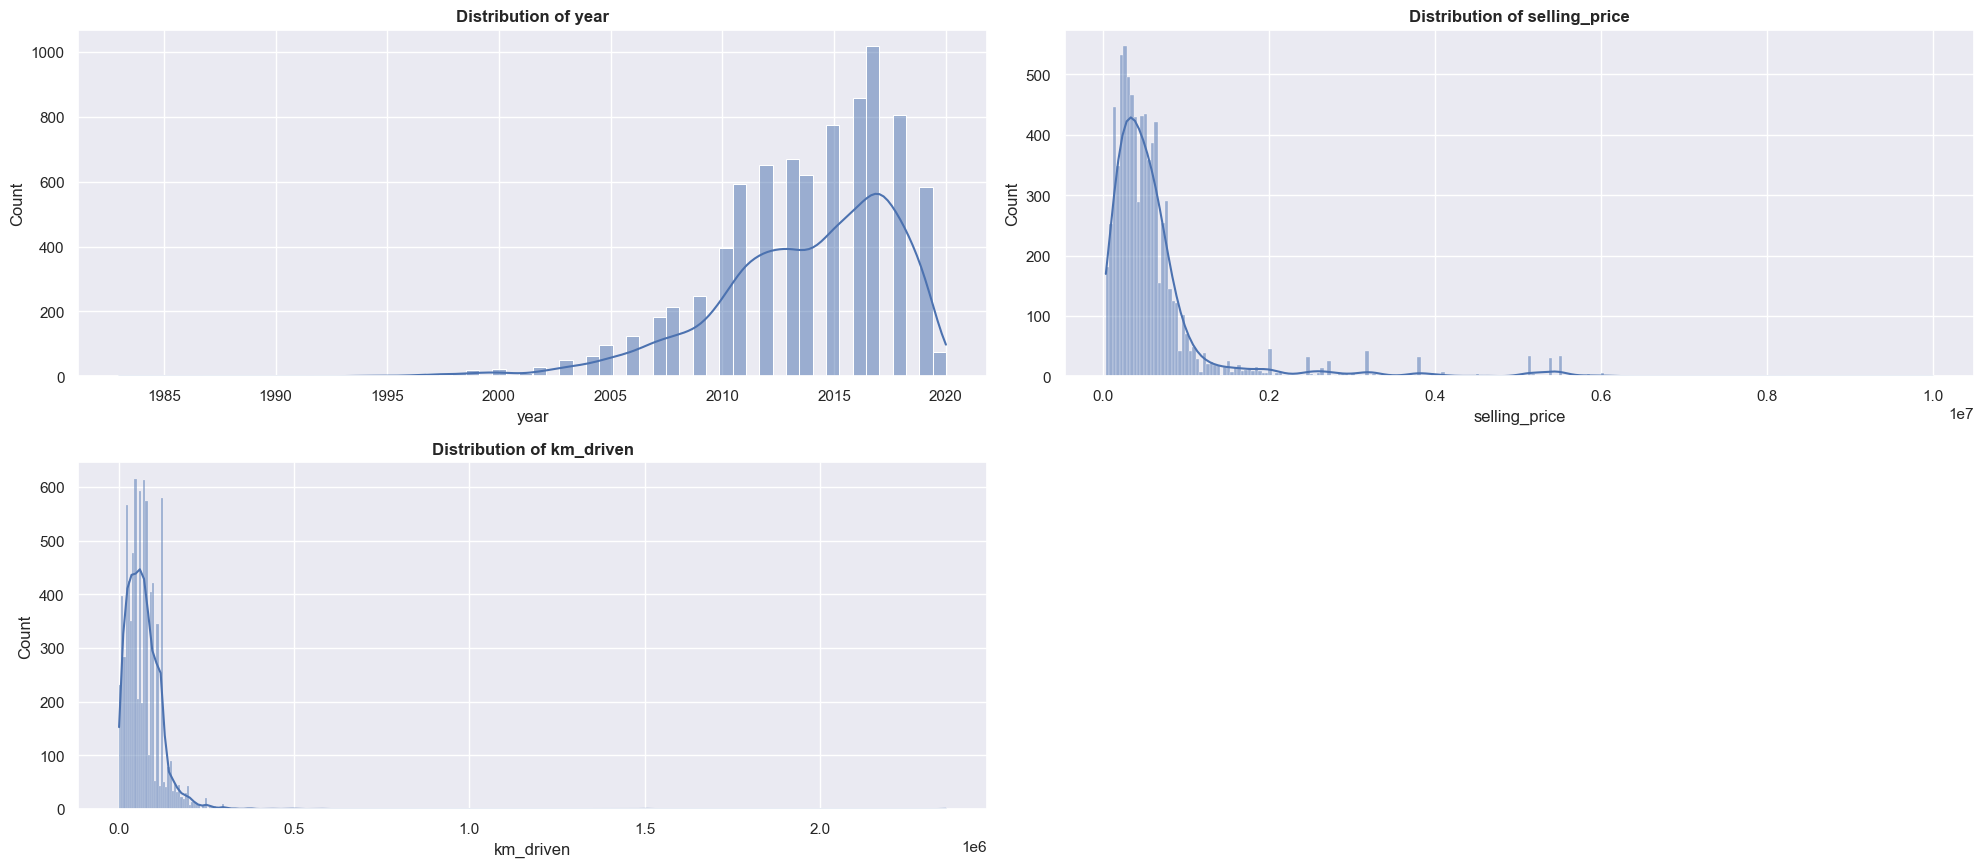

In [66]:
plt.figure(figsize=(20, 30))

for i, column in enumerate(numerical_columns):
    plt.subplot(len(data.columns)//2 + len(data.columns)%2, 2, i+1)
    sns.histplot(data[column], kde=True)
    plt.title(f"Distribution of {column}", fontweight="bold")

plt.tight_layout()
plt.show()

Categorical columns

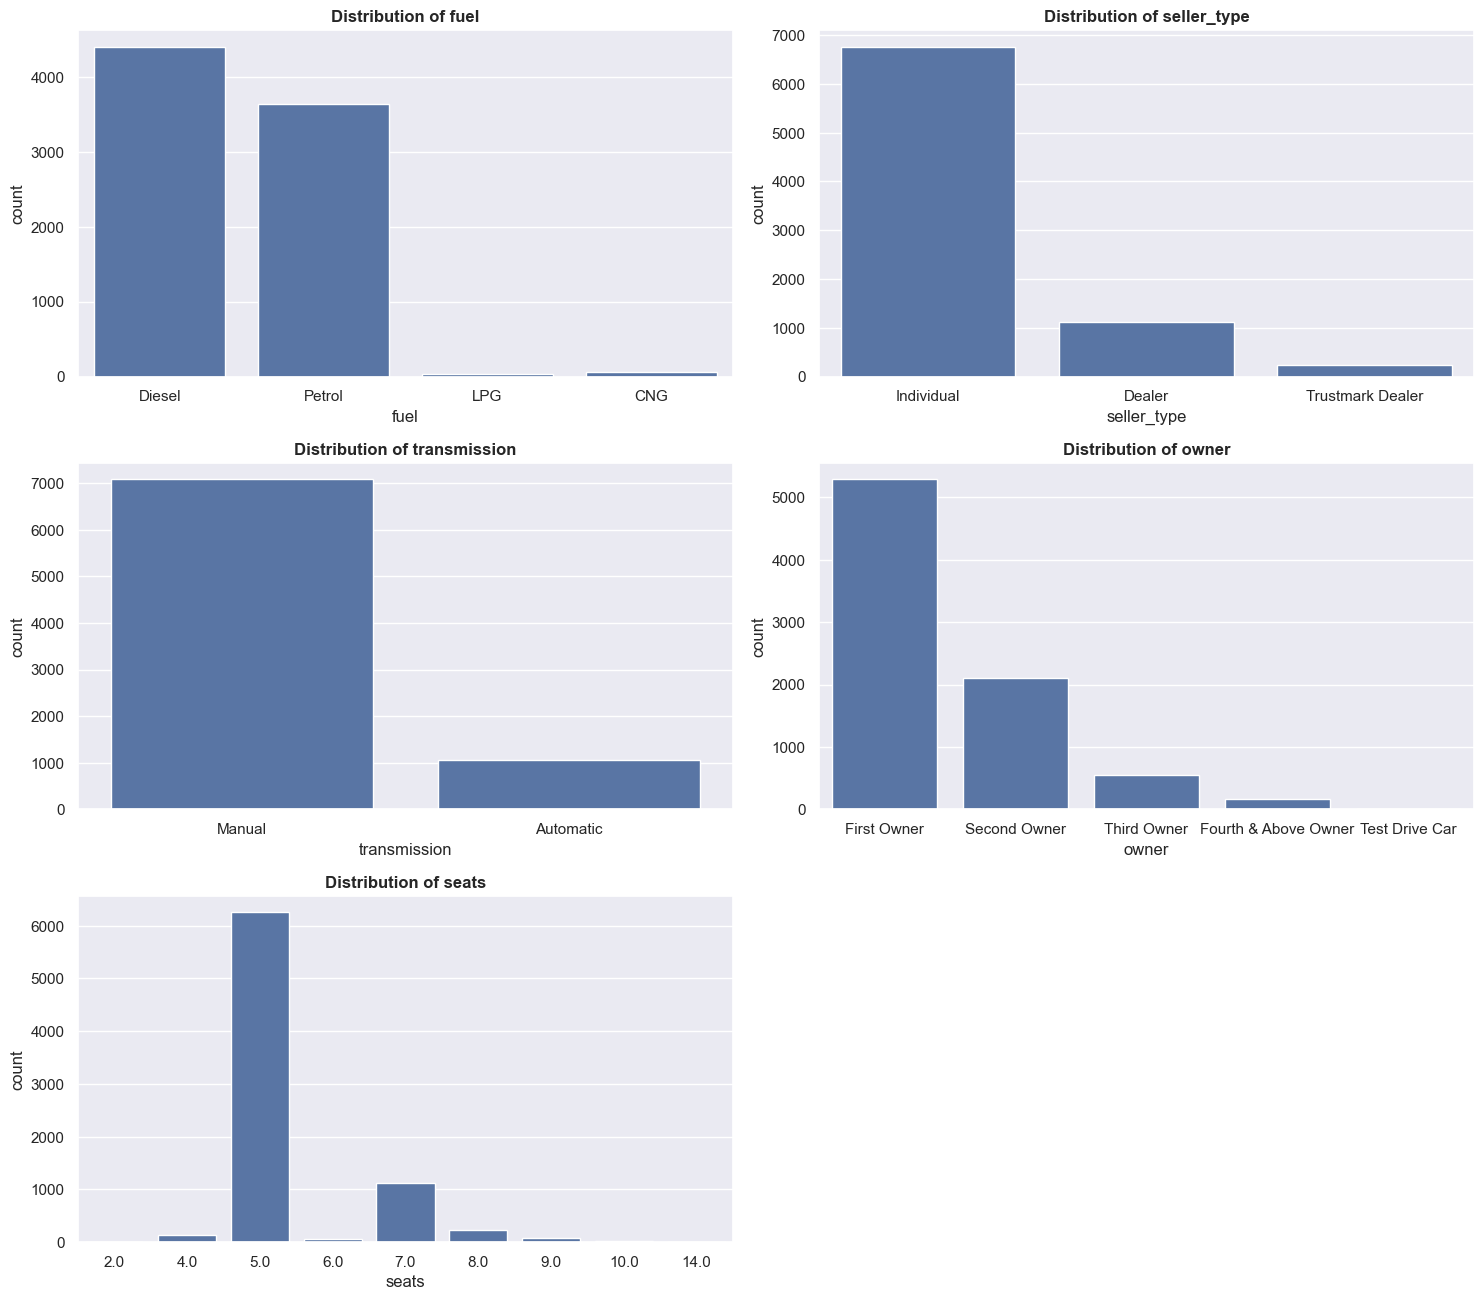

In [67]:
plt.figure(figsize=(15, 30))

for i, column in enumerate(categorical_columns):
    plt.subplot(len(data.columns)//2 + len(data.columns)%2, 2, i+1)
    sns.countplot(data=data, x=data[column])
    plt.title(f"Distribution of {column}", fontweight="bold")

plt.tight_layout()
plt.show()

Boolean columns

In [68]:
plt.figure(figsize=(15, 60))

for i, column in enumerate(boolean_columns):
    plt.subplot(len(data.columns)//2 + len(data.columns)%2, 2, i+1)
    sns.countplot(data=data, x=data[column])
    plt.title(f"Distribution of {column}", fontweight="bold")

plt.tight_layout()
plt.show()

<Figure size 1500x6000 with 0 Axes>

### **Correlations**

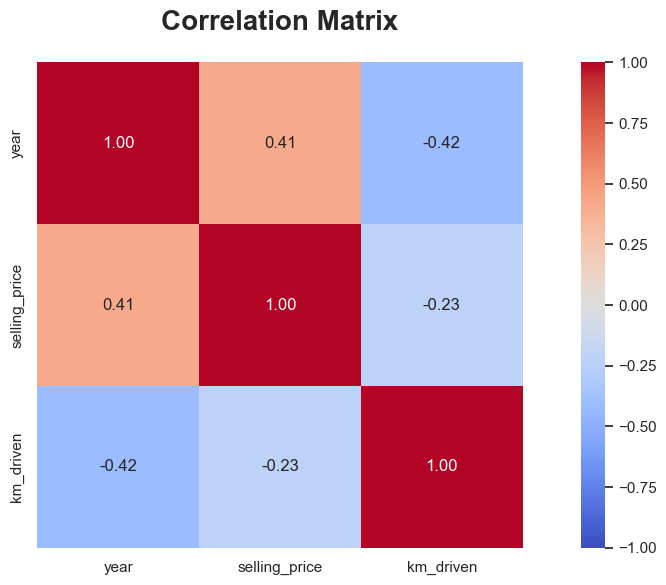

In [69]:
correlation_matrix = data[numerical_columns].corr()

plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix, 
    annot=True, 
    square=True, 
    cmap="coolwarm", 
    fmt=".2f",
    vmin=-1, vmax=1
)
plt.title("Correlation Matrix", fontweight="bold", fontsize=20, y=1.05)

plt.tight_layout()
plt.show()

### **Outliers**

Text(0.5, 1.0, 'Boxplot for Numerical Columns')

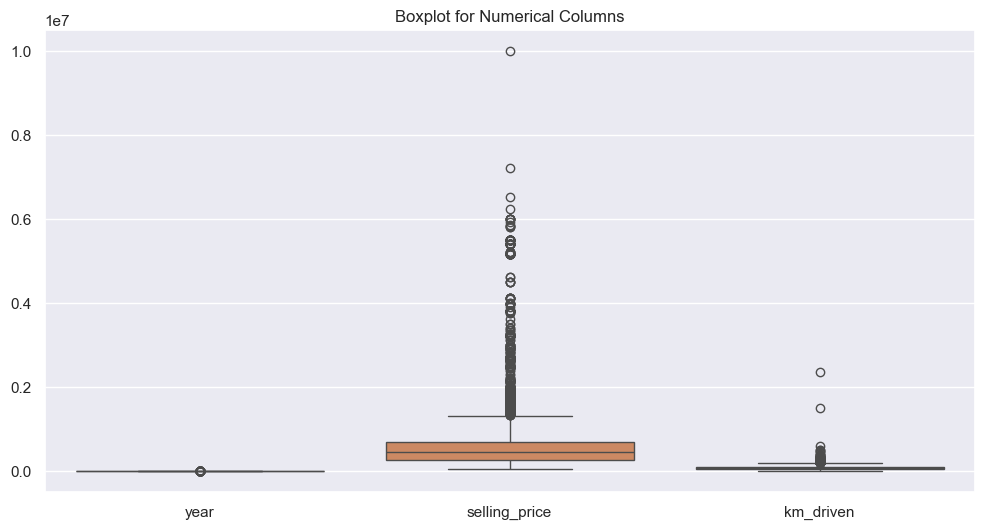

In [70]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[numerical_columns])
plt.title("Boxplot for Numerical Columns")


## Step 4. Deal with missing values

In [71]:
def show_missing_count():
    missing_df = pd.DataFrame(df.isna().sum(), columns=["missing_count"])
    missing_df = missing_df[missing_df["missing_count"] > 0]

    return missing_df

show_missing_count()

,missing_count
seats,221
max_power_bhp,215
power_to_weight_ratio,221
fuel_efficiency,221


Deal with column `seats`

In [72]:
df.seats.fillna(df.seats.median(), inplace=True)
show_missing_count()

,missing_count
max_power_bhp,215
power_to_weight_ratio,221
fuel_efficiency,221


Deal with column `max_power_bhp`

In [73]:
df.max_power_bhp.fillna(df.max_power_bhp.median(), inplace=True)
show_missing_count()

,missing_count
power_to_weight_ratio,221
fuel_efficiency,221


Deal with column `power_to_weight_ratio`

In [74]:
df.power_to_weight_ratio.fillna(df.power_to_weight_ratio.median(), inplace=True)
show_missing_count()

,missing_count
fuel_efficiency,221


In [75]:
df.fuel_efficiency.fillna(df.fuel_efficiency.median(), inplace=True)
show_missing_count()

,missing_count


## Step 5: Modelling

The goal for this dataset is to create a classification model that can predict the column `diagnosis`

### Import modelling libraries

In [134]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.python.keras.callbacks import EarlyStopping

    # Optimizers
from keras.optimizers import Adam

    # Reguliarizers
from keras.regularizers import l2


### train_test_split

In [135]:
df.columns

Index(['year', 'selling_price', 'km_driven', 'seats', 'age_of_car',
       'mileage_per_year', 'engine_cc', 'max_power_bhp',
       'power_to_weight_ratio', 'fuel_efficiency', 'transmission_manual',
       'previous_owners', 'fuel_CNG', 'fuel_Diesel', 'fuel_LPG', 'fuel_Petrol',
       'seller_type_Dealer', 'seller_type_Individual',
       'seller_type_Trustmark Dealer', 'make_Ambassador', 'make_Ashok',
       'make_Audi', 'make_BMW', 'make_Chevrolet', 'make_Daewoo', 'make_Datsun',
       'make_Fiat', 'make_Force', 'make_Ford', 'make_Honda', 'make_Hyundai',
       'make_Isuzu', 'make_Jaguar', 'make_Jeep', 'make_Kia', 'make_Land',
       'make_Lexus', 'make_MG', 'make_Mahindra', 'make_Maruti',
       'make_Mercedes-Benz', 'make_Mitsubishi', 'make_Nissan', 'make_Opel',
       'make_Peugeot', 'make_Renault', 'make_Skoda', 'make_Tata',
       'make_Toyota', 'make_Volkswagen', 'make_Volvo'],
      dtype='object')

In [136]:
X = df.drop(columns=["selling_price"])
y = df["selling_price"]

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)


scaler = MinMaxScaler()
X_train_stand = scaler.fit_transform(X_train)
X_test_stand = scaler.transform(X_test)


### **Sequential()**

#### 1. Architecture

In [138]:
def get_model():

    model = Sequential()
    n_cols = X_train_stand.shape[1]

    model.add(Dense(64, activation="relu", kernel_regularizer=l2(0.001), input_shape=(n_cols,)))
    model.add(Dense(32, activation="relu", kernel_regularizer=l2(0.001) ))
    model.add(Dense(16, activation="relu", kernel_regularizer=l2(0.001) ))
    model.add(Dense(1))

    return model

model_1 = get_model()

#### 2. Compile

In [139]:
custom_lr = 0.001 # custom learning rate
optimizer = Adam(learning_rate=custom_lr, clipnorm=1.0)

model_1.compile(optimizer=optimizer, loss="mean_absolute_error")

#### 3. Fit the model

In [140]:
early_stopping =  EarlyStopping(patience=10)

fit_1 = model_1.fit(X_train_stand, y_train, 
                    epochs=1000, batch_size=32, validation_split=0.2,
                    callbacks=[early_stopping], verbose=0
                )

#### 4. Evaluation

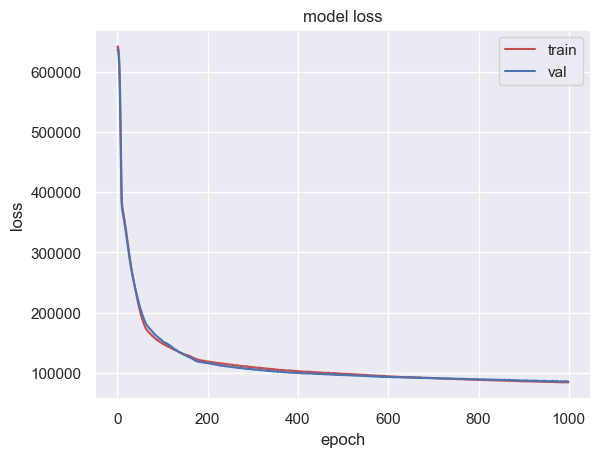

In [141]:
plt.plot(fit_1.history['loss'],'r')
plt.plot(fit_1.history['val_loss'],'b')

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

#### 4.1. Zoom into last 100 Epochs

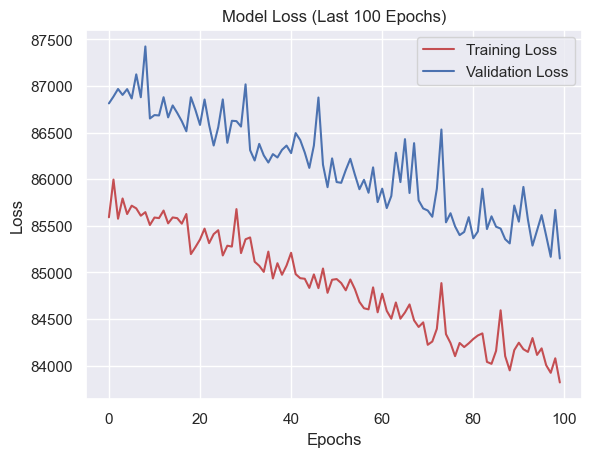

In [142]:
loss = fit_1.history['loss'][-100:]
val_loss = fit_1.history['val_loss'][-100:]
epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')

plt.title('Model Loss (Last 100 Epochs)')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()

plt.show()

### **Sequential()** with `Dropout()`

#### 1. Architecture

In [143]:
def get_model():

    model = Sequential()
    n_cols = X_train_stand.shape[1]

    model.add(Dense(64, activation="relu", kernel_regularizer=l2(0.001) , input_shape=(n_cols,)))
    model.add(Dropout(0.2))

    model.add(Dense(32, activation="relu", kernel_regularizer=l2(0.001) ))
    model.add(Dropout(0.2))

    model.add(Dense(16, activation="relu", kernel_regularizer=l2(0.001) ))
    model.add(Dropout(0.2))
    
    model.add(Dense(1))

    return model

model_2 = get_model()

#### 2. Compile

In [144]:
custom_lr = 0.001 # custom learning rate
optimizer = Adam(learning_rate=custom_lr, clipnorm=1.0)

model_2.compile(optimizer=optimizer, loss="mean_absolute_error")

#### 3. Fit the model

In [145]:
early_stopping =  EarlyStopping(patience=10)

fit_2 = model_2.fit(X_train_stand, y_train, 
                    epochs=1000, batch_size=32, validation_split=0.2,
                    callbacks=[early_stopping], verbose=0
                )

#### 4. Evaluation

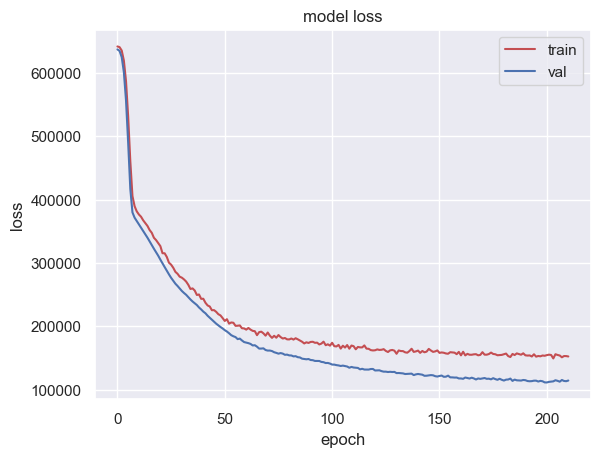

In [146]:
plt.plot(fit_2.history['loss'],'r')
plt.plot(fit_2.history['val_loss'],'b')

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

#### 4.1. Zoom into last 100 Epochs

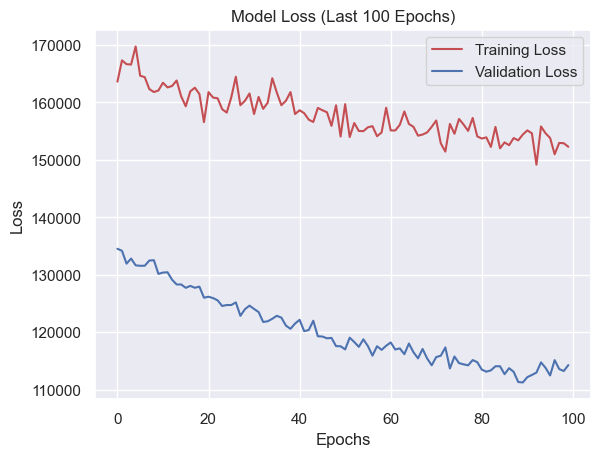

In [147]:
loss = fit_2.history['loss'][-100:]
val_loss = fit_2.history['val_loss'][-100:]
epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')

plt.title('Model Loss (Last 100 Epochs)')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()

plt.show()

### **Sequential()** with `Dropout()` and `BatchNormalization()`

#### 1. Architecture

In [148]:
def get_model():

    model = Sequential()
    n_cols = X_train_stand.shape[1]

    model.add(Dense(64, activation="relu", kernel_regularizer=l2(0.001), input_shape=(n_cols,)))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())

    model.add(Dense(32, activation="relu", kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())

    model.add(Dense(16, activation="relu", kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())

    model.add(Dense(1))

    return model

model_3 = get_model()

#### 2. Compile

In [149]:
custom_lr = 0.001 # custom learning rate
optimizer = Adam(learning_rate=custom_lr, clipnorm=1.0)

model_3.compile(optimizer=optimizer, loss="mean_absolute_error")

#### 3. Fit the model

In [150]:
early_stopping =  EarlyStopping(patience=10)

fit_3 = model_3.fit(X_train_stand, y_train, 
                    epochs=1000, batch_size=32, validation_split=0.2,
                    callbacks=[early_stopping], verbose=0
                )

#### 4. Evaluation

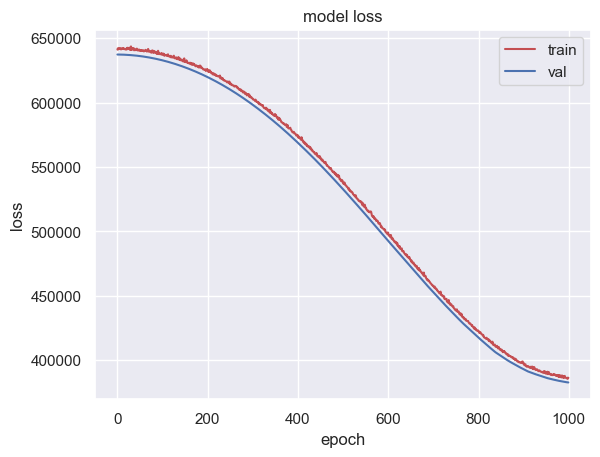

In [151]:
plt.plot(fit_3.history['loss'],'r')
plt.plot(fit_3.history['val_loss'],'b')

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

#### 4.1. Zoom into last 100 Epochs

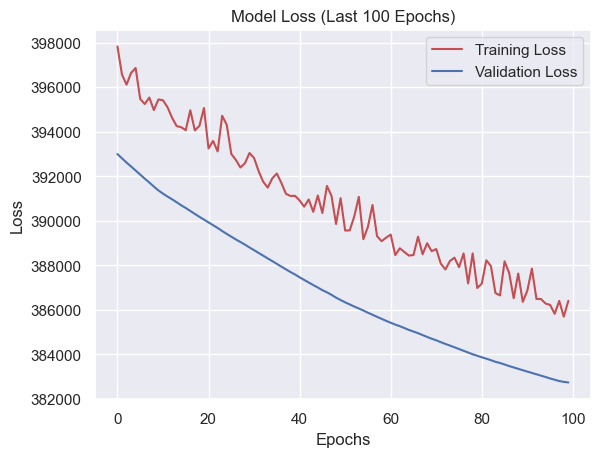

In [152]:
loss = fit_3.history['loss'][-100:]
val_loss = fit_3.history['val_loss'][-100:]
epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')

plt.title('Model Loss (Last 100 Epochs)')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()

plt.show()

## Step 6: Comparing all models

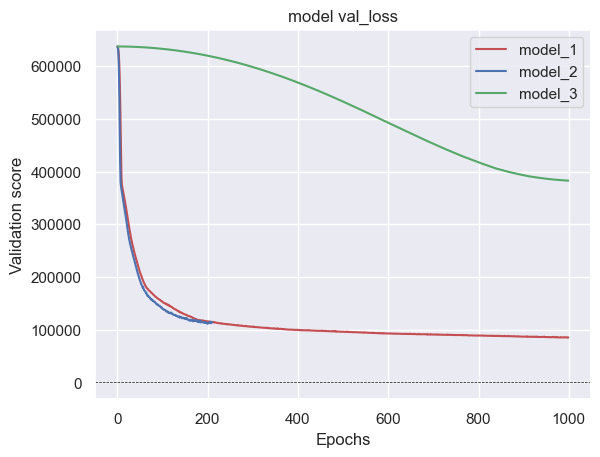

In [153]:
plt.plot(fit_1.history["val_loss"], 'r', 
         fit_2.history["val_loss"], 'b',
         fit_3.history["val_loss"], 'g',
         )

plt.title('model val_loss')
plt.xlabel('Epochs')
plt.ylabel('Validation score')
plt.legend(['model_1', 'model_2', 'model_3'], loc='upper right')

plt.axhline(0.08, color='black', linestyle='--', linewidth=.5)

plt.show()

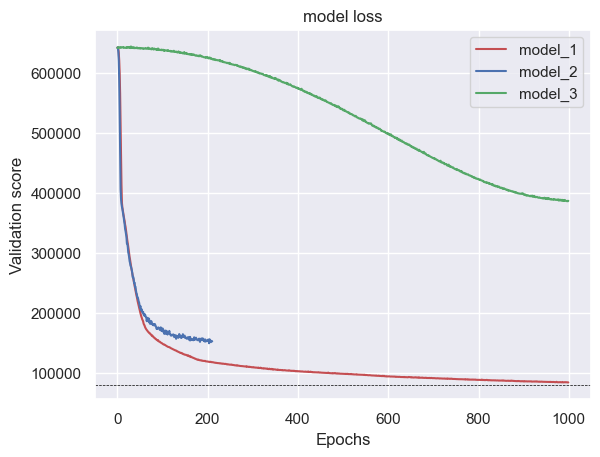

In [157]:
plt.plot(fit_1.history["loss"], 'r', 
         fit_2.history["loss"], 'b',
         fit_3.history["loss"], 'g',
         )

plt.title('model loss')
plt.xlabel('Epochs')
plt.ylabel('Validation score')
plt.legend(['model_1', 'model_2', 'model_3'], loc='upper right')

plt.axhline(80000, color='black', linestyle='--', linewidth=.5)

plt.show()

### Zoom into last 100 Epochs

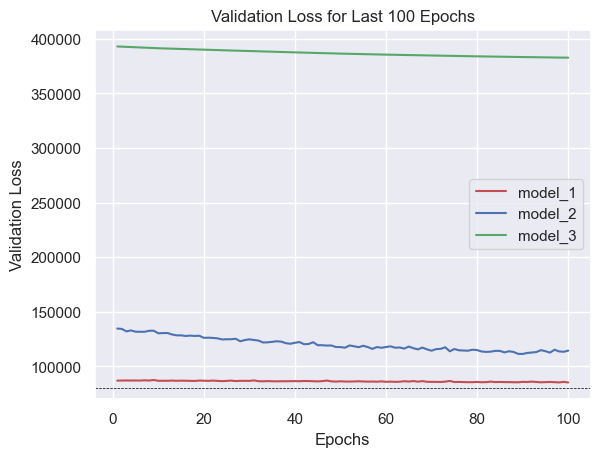

In [159]:
# Extract the last 100 epochs for each model
epochs = range(1, 101)  # Last 100 epochs

val_loss_1 = fit_1.history["val_loss"][-100:]
val_loss_2 = fit_2.history["val_loss"][-100:]
val_loss_3 = fit_3.history["val_loss"][-100:]

plt.plot(epochs, val_loss_1, 'r', label='model_1')
plt.plot(epochs, val_loss_2, 'b', label='model_2')
plt.plot(epochs, val_loss_3, 'g', label='model_3')

plt.title('Validation Loss for Last 100 Epochs')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()

plt.axhline(80000, color='black', linestyle='--', linewidth=.5)

plt.show()

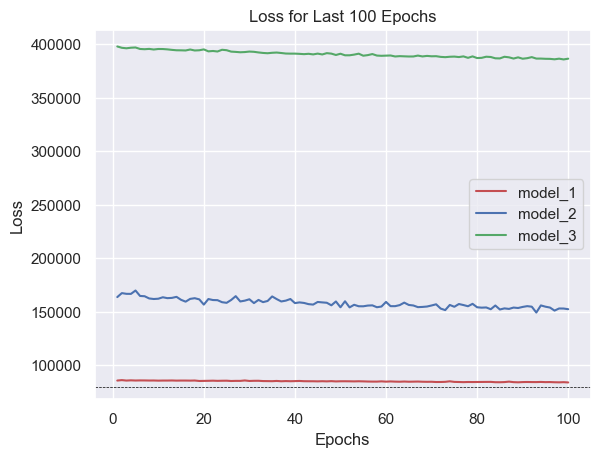

In [158]:
# Extract the last 100 epochs for each model
epochs = range(1, 101)  # Last 100 epochs

loss_1 = fit_1.history["loss"][-100:]
loss_2 = fit_2.history["loss"][-100:]
loss_3 = fit_3.history["loss"][-100:]

plt.plot(epochs, loss_1, 'r', label='model_1')
plt.plot(epochs, loss_2, 'b', label='model_2')
plt.plot(epochs, loss_3, 'g', label='model_3')

plt.title('Loss for Last 100 Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.axhline(80000, color='black', linestyle='--', linewidth=.5)

plt.show()

In [ ]:
fit_1.history